In [2]:
import os, importlib, sys, time

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import scipy.linalg as la
import scipy.stats as stats

In [5]:
import freqepid

In [6]:
# %load_ext jupyternotify

# 1. parameters

In [7]:
T = 120
T0 = 40

In [8]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [9]:
alpha = 0.01
r_Y = 10

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [10]:
d = 2
beta = np.array([0, -2.2])

In [11]:
r_I = 10
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [12]:
mu = np.log(100)

$$I_{[-T_0,0)} = \exp(\mu_0)$$

# 2. simulation

## load simulation

In [13]:
data = pd.read_feather('data/simulation_randinf.feather')

In [14]:
data_i = data[data['sim']==0]
A = np.stack([np.full(T, 1), data_i["intervention"].to_numpy()], -1)
R = data_i["R"].to_numpy()
EI = data_i["EI"].to_numpy()
I = data_i["infection"].to_numpy()
EY = data_i["EY"].to_numpy()
Y = data_i["death"].to_numpy()

In [15]:
data_i

,sim,date,R,EI,infection,EY,death,intervention
0,0,0,3.250000,324.997762,356.0,0.956069,0,0
1,0,1,3.250000,340.245831,298.0,0.962543,2,0
2,0,2,3.250000,392.196621,409.0,0.968283,0,0
3,0,3,3.250000,471.047829,545.0,0.973654,1,0
4,0,4,3.250000,581.900998,584.0,0.979752,1,0
...,...,...,...,...,...,...,...,...
115,0,115,0.648378,371.111321,316.0,15.952502,18,1
116,0,116,0.648378,353.729962,301.0,15.065929,6,1
117,0,117,0.648378,334.027910,314.0,14.232065,22,1
118,0,118,0.648378,313.305734,285.0,13.440178,20,1


# 3. fit by coordinate descent method

In [16]:
model = freqepid.Model(GPi['g'], GPi['pi'], alpha, K, T0, 'nbinom')

In [17]:
result = pd.read_feather('result_epidemia_nbinom_randinf.feather')

In [18]:
result

,R|(Intercept),R|intervention,death|(Intercept),seeds[1]
0,-0.110035,-2.05251,0.135270,80.7990
1,-0.163810,-1.99832,-0.299005,130.0500
2,0.000687,-2.18618,-0.156195,79.8541
3,-0.052178,-2.13279,-0.292111,98.0857
4,-0.180030,-1.98740,-0.100121,121.3900
...,...,...,...,...
995,-0.067037,-2.09992,-0.092084,85.4463
996,-0.042664,-2.11383,-0.230532,82.4636
997,-0.083346,-2.05574,-0.156393,87.3573
998,-0.031585,-2.15333,0.052194,74.8234


In [19]:
bsmp = result.iloc[:,:2].to_numpy()
msmp = np.log(result.iloc[:,3].to_numpy())

In [20]:
bepi = np.mean(bsmp,0)
mepi = np.mean(msmp)

In [21]:
mepi, bepi

(4.47301922335973, array([-0.10257763, -2.05373739]))

In [22]:
Repi = model.predict_R(A, bepi)
Iepi = model.predict_I(A, mepi, bepi)
EYepi = model.predict_EY(A, mepi, bepi)

## plots

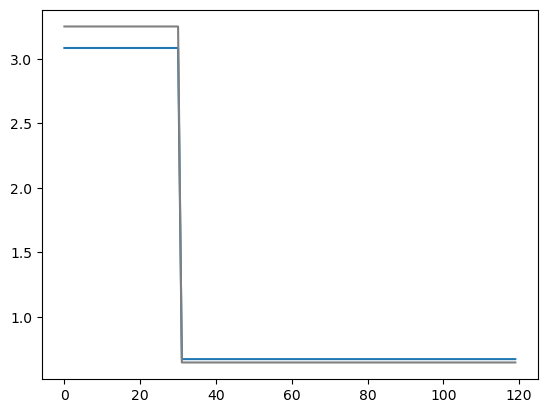

In [23]:
plt.plot(Repi)
plt.plot(R, color='grey')

<BarContainer object of 120 artists>

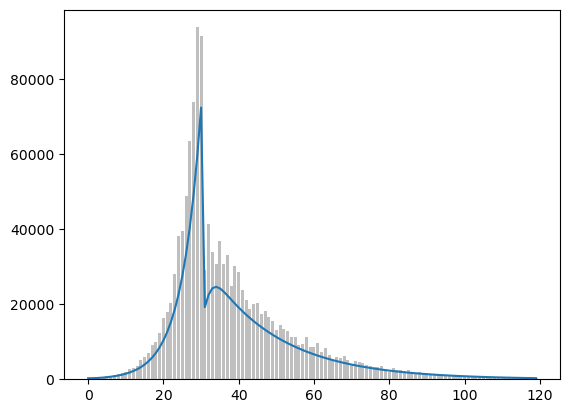

In [24]:
plt.plot(Iepi)
plt.bar(np.arange(T), I, color='grey', alpha=0.5)

<BarContainer object of 120 artists>

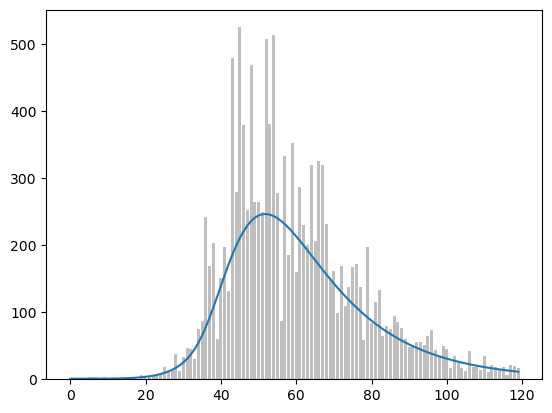

In [25]:
plt.plot(EYepi)
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)

# 4. Confidence Region

In [26]:
tsmp = np.concatenate([msmp[:,None], bsmp], -1)

In [43]:
theta = np.array([mu, *beta])
tepi = np.mean(tsmp, 0)
tname = [r"$\mu$", r"$\beta_0$", r"$\beta_1$"]
tlimit = [[3, 8], [-1, 0.5], [-3, -1]]

In [38]:
Vepi = np.cov(tsmp.T)

In [39]:
Vepi[-2:,-2:]

array([[ 0.00433823, -0.00499257],
       [-0.00499257,  0.00608815]])

In [40]:
chi_pa = freqepid.CV(d+1).chi_pa(0.05)

(-3.0, -1.0)

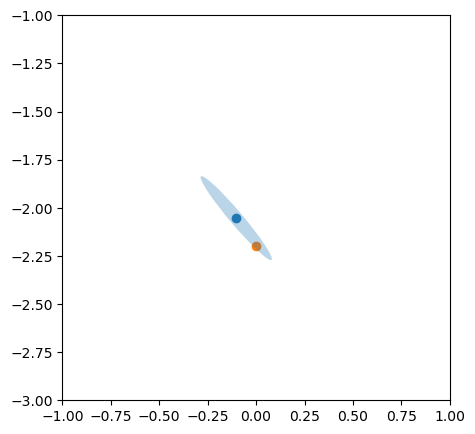

In [41]:
plt.figure(figsize=(5,5))
p = plt.scatter(*tepi[-2:])
plt.scatter(*beta)
freqepid.confidence_ellipse(
    tepi[-2:], Vepi[-2:,-2:], 
    n_std=chi_pa, facecolor=p.get_facecolor(), alpha=0.3)
plt.xlim(-1, 1); plt.ylim(-3,-1)

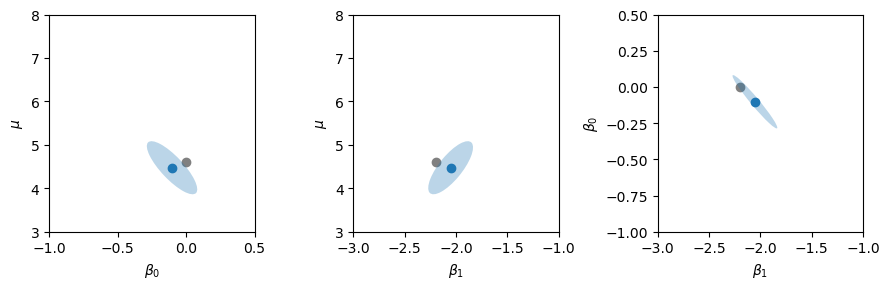

In [45]:
plt.figure(figsize=(9,3))
for i in np.arange(d+1):
    for j in np.arange(i+1,d+1):
        plt.subplot(1,3,i+j)
        p = plt.scatter(tepi[j], tepi[i])
        plt.scatter(theta[j], theta[i], color='grey')
        freqepid.confidence_ellipse(
            [tepi[j],tepi[i]], Vepi[np.ix_([j,i],[j,i])], 
            n_std=chi_pa, facecolor=p.get_facecolor(), alpha=0.3)
        plt.xlabel(tname[j]); plt.ylabel(tname[i])
        plt.xlim(tlimit[j]); plt.ylim(tlimit[i])
plt.tight_layout()

# 5. Confidence Band

In [46]:
conf_R, beta_min, beta_max = \
model.confidence_R(A, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.190sec.
optimization at t = 2 finished, lapse: 0.167sec.
optimization at t = 3 finished, lapse: 0.168sec.
optimization at t = 4 finished, lapse: 0.168sec.
optimization at t = 5 finished, lapse: 0.168sec.
optimization at t = 6 finished, lapse: 0.167sec.
optimization at t = 7 finished, lapse: 0.169sec.
optimization at t = 8 finished, lapse: 0.166sec.
optimization at t = 9 finished, lapse: 0.168sec.
optimization at t = 10 finished, lapse: 0.167sec.
optimization at t = 11 finished, lapse: 0.166sec.
optimization at t = 12 finished, lapse: 0.166sec.
optimization at t = 13 finished, lapse: 0.169sec.
optimization at t = 14 finished, lapse: 0.167sec.
optimization at t = 15 finished, lapse: 0.169sec.
optimization at t = 16 finished, lapse: 0.166sec.
optimization at t = 17 finished, lapse: 0.165sec.
optimization at t = 18 finished, lapse: 0.164sec.
optimization at t = 19 finished, lapse: 0.169sec.
optimization at t = 20 finished, lapse: 0.167sec.
optimizat

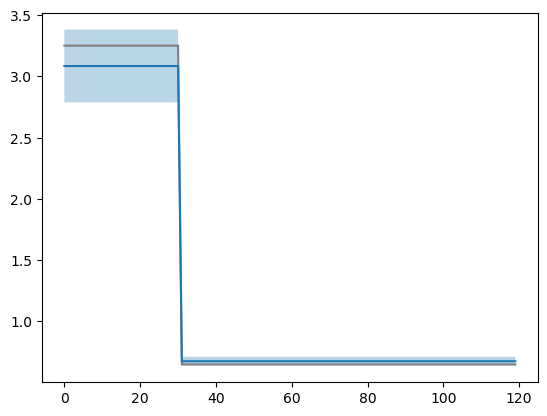

In [48]:
plt.plot(R, color='grey')
plt.plot(Repi)
plt.fill_between(np.arange(T), conf_R[:,0], conf_R[:,1], alpha=0.3)

In [50]:
conf_I, _, _ = \
model.confidence_I(A, mepi, bepi, Vepi[-3:,-3:], chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.458sec.
optimization at t = 2 finished, lapse: 0.097sec.
optimization at t = 3 finished, lapse: 0.172sec.
optimization at t = 4 finished, lapse: 0.071sec.
optimization at t = 5 finished, lapse: 0.102sec.
optimization at t = 6 finished, lapse: 0.072sec.
optimization at t = 7 finished, lapse: 0.129sec.
optimization at t = 8 finished, lapse: 0.072sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 9 finished, lapse: 0.076sec.
optimization at t = 10 finished, lapse: 0.069sec.
optimization at t = 11 finished, lapse: 0.104sec.
optimization at t = 12 finished, lapse: 0.170sec.
optimization at t = 13 finished, lapse: 0.182sec.
optimization at t = 14 finished, lapse: 0.180sec.
optimization at t = 15 finished, lapse: 0.177sec.
optimization at t = 16 finished, lapse: 0.174sec.
optimization at t = 17 finished, lapse: 0.217sec.
optimization at t = 18 finished, lapse: 0.197sec.
optimization at t = 19 finished, lapse: 0.241sec.
optimization at t = 20 finished, lapse: 0.170sec.
optimization at t = 21 finished, lapse: 0.192sec.
optimization at t = 22 finished, lapse: 0.230sec.
optimization at t = 23 finished, lapse: 0.250sec.
optimization at t = 24 finished, lapse: 0.154sec.
optimization at t = 25 finished, lapse: 0.189sec.
optimization at t = 26 finished, lapse: 0.173sec.
optimization at t = 27 finished, lapse: 0.202sec.
optimization at t = 28 finished, lapse: 0.225sec.
o

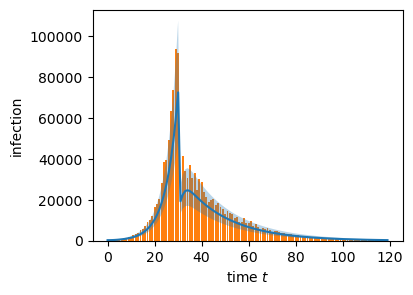

In [55]:
plt.figure(figsize = (4,3))
plt.xlabel("time $t$"); plt.ylabel("infection")
plt.bar(np.arange(T), I, color='C1')
plt.plot(Iepi)
plt.fill_between(np.arange(T), conf_I[:,0], conf_I[:,1], alpha=0.3)

In [52]:
conf_EY, theta_min, theta_max = \
model.confidence_EY(A, mepi, bepi, Vepi[-3:,-3:], chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 1.577sec.
optimization at t = 2 finished, lapse: 0.346sec.
optimization at t = 3 finished, lapse: 2.032sec.
optimization at t = 4 finished, lapse: 1.109sec.
optimization at t = 5 finished, lapse: 0.558sec.
optimization at t = 6 finished, lapse: 2.760sec.
optimization at t = 7 finished, lapse: 0.699sec.
optimization at t = 8 finished, lapse: 0.632sec.
optimization at t = 9 finished, lapse: 0.489sec.
optimization at t = 10 finished, lapse: 1.383sec.
optimization at t = 11 finished, lapse: 0.873sec.
optimization at t = 12 finished, lapse: 0.635sec.
optimization at t = 13 finished, lapse: 0.313sec.
optimization at t = 14 finished, lapse: 0.387sec.
optimization at t = 15 finished, lapse: 0.216sec.
optimization at t = 16 finished, lapse: 0.215sec.
optimization at t = 17 finished, lapse: 0.471sec.
optimization at t = 18 finished, lapse: 0.372sec.
optimization at t = 19 finished, lapse: 0.254sec.
optimization at t = 20 finished, lapse: 0.208sec.
optimizat

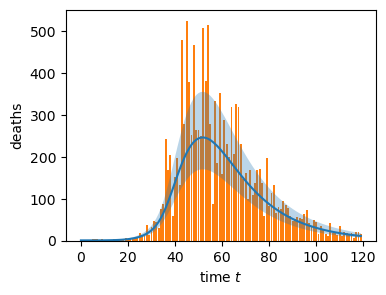

In [56]:
plt.figure(figsize = (4,3))
plt.xlabel("time $t$"); plt.ylabel("deaths")
plt.bar(np.arange(T), Y, color='C1')
plt.plot(EYepi)
plt.fill_between(np.arange(T), conf_EY[:,0], conf_EY[:,1], alpha=0.3)

# 6. Confidence Interval

## A = 1

In [42]:
Tf = 60
Af = np.zeros([Tf, d])

In [43]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 1)

In [44]:
Ae = np.concatenate([A, Af], 0)

In [46]:
conf_band, beta_min, beta_max = \
model.confidence_R(Ae, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.189sec.
optimization at t = 2 finished, lapse: 0.168sec.
optimization at t = 3 finished, lapse: 0.169sec.
optimization at t = 4 finished, lapse: 0.169sec.
optimization at t = 5 finished, lapse: 0.170sec.
optimization at t = 6 finished, lapse: 0.170sec.
optimization at t = 7 finished, lapse: 0.170sec.
optimization at t = 8 finished, lapse: 0.170sec.
optimization at t = 9 finished, lapse: 0.171sec.
optimization at t = 10 finished, lapse: 0.169sec.
optimization at t = 11 finished, lapse: 0.171sec.
optimization at t = 12 finished, lapse: 0.171sec.
optimization at t = 13 finished, lapse: 0.172sec.
optimization at t = 14 finished, lapse: 0.170sec.
optimization at t = 15 finished, lapse: 0.172sec.
optimization at t = 16 finished, lapse: 0.170sec.
optimization at t = 17 finished, lapse: 0.169sec.
optimization at t = 18 finished, lapse: 0.170sec.
optimization at t = 19 finished, lapse: 0.173sec.
optimization at t = 20 finished, lapse: 0.169sec.
optimizat

optimization at t = 167 finished, lapse: 0.048sec.
optimization at t = 168 finished, lapse: 0.060sec.
optimization at t = 169 finished, lapse: 0.045sec.
optimization at t = 170 finished, lapse: 0.060sec.
optimization at t = 171 finished, lapse: 0.046sec.
optimization at t = 172 finished, lapse: 0.059sec.
optimization at t = 173 finished, lapse: 0.045sec.
optimization at t = 174 finished, lapse: 0.059sec.
optimization at t = 175 finished, lapse: 0.048sec.
optimization at t = 176 finished, lapse: 0.060sec.
optimization at t = 177 finished, lapse: 0.046sec.
optimization at t = 178 finished, lapse: 0.059sec.
optimization at t = 179 finished, lapse: 0.048sec.
optimization at t = 180 finished, lapse: 0.060sec.


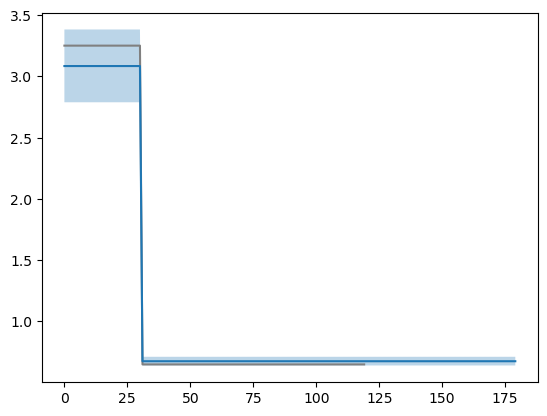

In [47]:
plt.plot(R, color='grey')
plt.plot(model.predict_R(Ae, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [48]:
conf_band, theta_min, theta_max = \
model.confidence_I(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.428sec.
optimization at t = 2 finished, lapse: 0.098sec.
optimization at t = 3 finished, lapse: 0.174sec.
optimization at t = 4 finished, lapse: 0.073sec.
optimization at t = 5 finished, lapse: 0.102sec.
optimization at t = 6 finished, lapse: 0.072sec.
optimization at t = 7 finished, lapse: 0.130sec.
optimization at t = 8 finished, lapse: 0.072sec.
optimization at t = 9 finished, lapse: 0.076sec.
optimization at t = 10 finished, lapse: 0.068sec.
optimization at t = 11 finished, lapse: 0.107sec.
optimization at t = 12 finished, lapse: 0.172sec.
optimization at t = 13 finished, lapse: 0.181sec.
optimization at t = 14 finished, lapse: 0.180sec.
optimization at t = 15 finished, lapse: 0.180sec.
optimization at t = 16 finished, lapse: 0.174sec.
optimization at t = 17 finished, lapse: 0.217sec.
optimization at t = 18 finished, lapse: 0.200sec.
optimization at t = 19 finished, lapse: 0.244sec.
optimization at t = 20 finished, lapse: 0.172sec.
optimizat

optimization at t = 164 finished, lapse: 0.639sec.
optimization at t = 165 finished, lapse: 1.307sec.
optimization at t = 166 finished, lapse: 1.207sec.
optimization at t = 167 finished, lapse: 0.603sec.
optimization at t = 168 finished, lapse: 0.584sec.
optimization at t = 169 finished, lapse: 1.215sec.
optimization at t = 170 finished, lapse: 0.870sec.
optimization at t = 171 finished, lapse: 0.978sec.
optimization at t = 172 finished, lapse: 1.025sec.
optimization at t = 173 finished, lapse: 0.818sec.
optimization at t = 174 finished, lapse: 1.225sec.
optimization at t = 175 finished, lapse: 0.402sec.
optimization at t = 176 finished, lapse: 0.428sec.
optimization at t = 177 finished, lapse: 0.871sec.
optimization at t = 178 finished, lapse: 0.389sec.
optimization at t = 179 finished, lapse: 0.728sec.
optimization at t = 180 finished, lapse: 1.169sec.


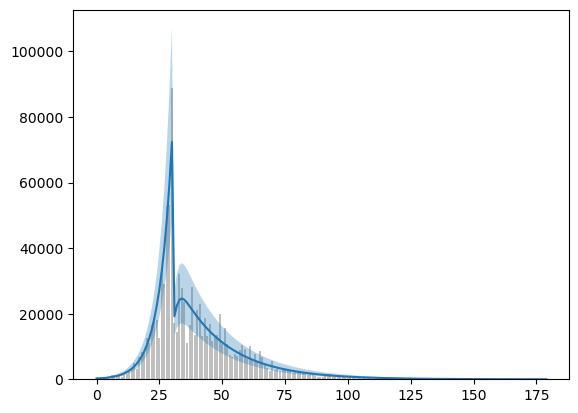

In [49]:
plt.bar(np.arange(T), I, color='grey', alpha=0.5)
plt.plot(model.predict_I(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [50]:
conf_band, theta_min, theta_max = \
model.confidence_EY(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 1.218sec.
optimization at t = 2 finished, lapse: 0.265sec.
optimization at t = 3 finished, lapse: 1.533sec.
optimization at t = 4 finished, lapse: 0.827sec.
optimization at t = 5 finished, lapse: 0.420sec.
optimization at t = 6 finished, lapse: 1.631sec.
optimization at t = 7 finished, lapse: 0.366sec.
optimization at t = 8 finished, lapse: 0.350sec.
optimization at t = 9 finished, lapse: 0.262sec.
optimization at t = 10 finished, lapse: 0.525sec.
optimization at t = 11 finished, lapse: 0.516sec.
optimization at t = 12 finished, lapse: 0.386sec.
optimization at t = 13 finished, lapse: 0.161sec.
optimization at t = 14 finished, lapse: 0.197sec.
optimization at t = 15 finished, lapse: 0.116sec.
optimization at t = 16 finished, lapse: 0.131sec.
optimization at t = 17 finished, lapse: 0.288sec.
optimization at t = 18 finished, lapse: 0.204sec.
optimization at t = 19 finished, lapse: 0.170sec.
optimization at t = 20 finished, lapse: 0.122sec.
optimizat

optimization at t = 164 finished, lapse: 0.462sec.
optimization at t = 165 finished, lapse: 0.552sec.
optimization at t = 166 finished, lapse: 0.462sec.
optimization at t = 167 finished, lapse: 0.456sec.
optimization at t = 168 finished, lapse: 0.403sec.
optimization at t = 169 finished, lapse: 0.513sec.
optimization at t = 170 finished, lapse: 0.449sec.
optimization at t = 171 finished, lapse: 0.429sec.
optimization at t = 172 finished, lapse: 0.401sec.
optimization at t = 173 finished, lapse: 0.394sec.
optimization at t = 174 finished, lapse: 0.426sec.
optimization at t = 175 finished, lapse: 0.416sec.
optimization at t = 176 finished, lapse: 0.408sec.
optimization at t = 177 finished, lapse: 0.488sec.
optimization at t = 178 finished, lapse: 0.433sec.
optimization at t = 179 finished, lapse: 0.426sec.
optimization at t = 180 finished, lapse: 0.424sec.


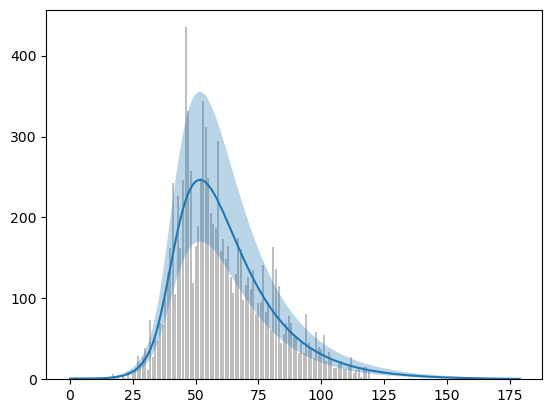

In [51]:
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)
plt.plot(model.predict_EY(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

## A = 0.5

In [34]:
Tf = 60
Af = np.zeros([Tf, d])

In [35]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [36]:
Ae = np.concatenate([A, Af], 0)

In [37]:
conf_band, beta_min, beta_max = \
model.confidence_R(Ae, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.173sec.
optimization at t = 2 finished, lapse: 0.177sec.
optimization at t = 3 finished, lapse: 0.177sec.
optimization at t = 4 finished, lapse: 0.175sec.
optimization at t = 5 finished, lapse: 0.178sec.
optimization at t = 6 finished, lapse: 0.175sec.
optimization at t = 7 finished, lapse: 0.178sec.
optimization at t = 8 finished, lapse: 0.176sec.
optimization at t = 9 finished, lapse: 0.174sec.
optimization at t = 10 finished, lapse: 0.174sec.
optimization at t = 11 finished, lapse: 0.178sec.
optimization at t = 12 finished, lapse: 0.174sec.
optimization at t = 13 finished, lapse: 0.175sec.
optimization at t = 14 finished, lapse: 0.174sec.
optimization at t = 15 finished, lapse: 0.175sec.
optimization at t = 16 finished, lapse: 0.178sec.
optimization at t = 17 finished, lapse: 0.176sec.
optimization at t = 18 finished, lapse: 0.175sec.
optimization at t = 19 finished, lapse: 0.176sec.
optimization at t = 20 finished, lapse: 0.178sec.
optimizat

optimization at t = 166 finished, lapse: 0.055sec.
optimization at t = 167 finished, lapse: 0.055sec.
optimization at t = 168 finished, lapse: 0.054sec.
optimization at t = 169 finished, lapse: 0.054sec.
optimization at t = 170 finished, lapse: 0.055sec.
optimization at t = 171 finished, lapse: 0.055sec.
optimization at t = 172 finished, lapse: 0.054sec.
optimization at t = 173 finished, lapse: 0.054sec.
optimization at t = 174 finished, lapse: 0.056sec.
optimization at t = 175 finished, lapse: 0.055sec.
optimization at t = 176 finished, lapse: 0.054sec.
optimization at t = 177 finished, lapse: 0.055sec.
optimization at t = 178 finished, lapse: 0.055sec.
optimization at t = 179 finished, lapse: 0.055sec.
optimization at t = 180 finished, lapse: 0.054sec.


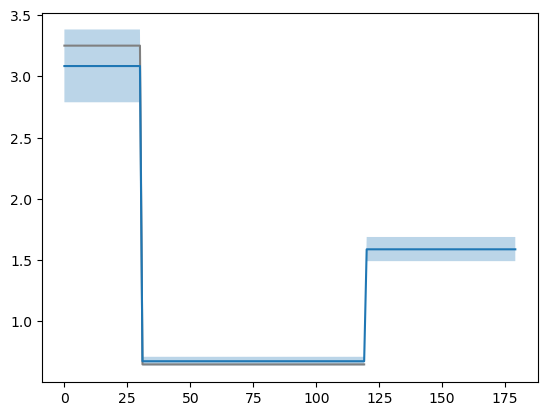

In [38]:
plt.plot(R, color='grey')
plt.plot(model.predict_R(Ae, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [39]:
conf_band, theta_min, theta_max = \
model.confidence_I(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.452sec.
optimization at t = 2 finished, lapse: 0.101sec.
optimization at t = 3 finished, lapse: 0.183sec.
optimization at t = 4 finished, lapse: 0.077sec.
optimization at t = 5 finished, lapse: 0.106sec.
optimization at t = 6 finished, lapse: 0.073sec.
optimization at t = 7 finished, lapse: 0.139sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 8 finished, lapse: 0.078sec.
optimization at t = 9 finished, lapse: 0.080sec.
optimization at t = 10 finished, lapse: 0.072sec.
optimization at t = 11 finished, lapse: 0.115sec.
optimization at t = 12 finished, lapse: 0.181sec.
optimization at t = 13 finished, lapse: 0.195sec.
optimization at t = 14 finished, lapse: 0.190sec.
optimization at t = 15 finished, lapse: 0.191sec.
optimization at t = 16 finished, lapse: 0.183sec.
optimization at t = 17 finished, lapse: 0.231sec.
optimization at t = 18 finished, lapse: 0.213sec.
optimization at t = 19 finished, lapse: 0.257sec.
optimization at t = 20 finished, lapse: 0.184sec.
optimization at t = 21 finished, lapse: 0.205sec.
optimization at t = 22 finished, lapse: 0.232sec.
optimization at t = 23 finished, lapse: 0.265sec.
optimization at t = 24 finished, lapse: 0.164sec.
optimization at t = 25 finished, lapse: 0.206sec.
optimization at t = 26 finished, lapse: 0.183sec.
optimization at t = 27 finished, lapse: 0.216sec.
op

optimization at t = 170 finished, lapse: 1.765sec.
optimization at t = 171 finished, lapse: 1.903sec.
optimization at t = 172 finished, lapse: 1.455sec.
optimization at t = 173 finished, lapse: 2.756sec.
optimization at t = 174 finished, lapse: 2.381sec.
optimization at t = 175 finished, lapse: 1.465sec.
optimization at t = 176 finished, lapse: 2.118sec.
optimization at t = 177 finished, lapse: 3.136sec.
optimization at t = 178 finished, lapse: 3.968sec.
optimization at t = 179 finished, lapse: 3.804sec.
optimization at t = 180 finished, lapse: 3.312sec.


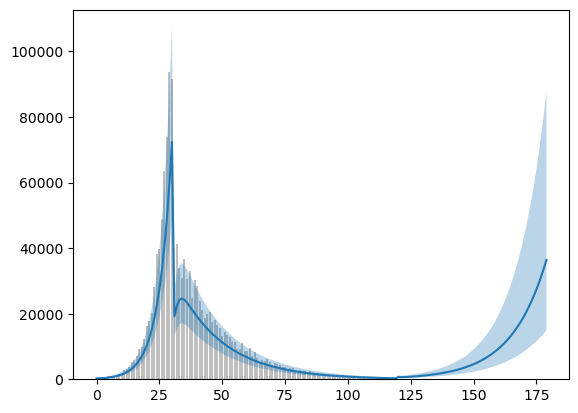

In [40]:
plt.bar(np.arange(T), I, color='grey', alpha=0.5)
plt.plot(model.predict_I(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [41]:
conf_band, theta_min, theta_max = \
model.confidence_EY(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 1.172sec.
optimization at t = 2 finished, lapse: 0.255sec.
optimization at t = 3 finished, lapse: 1.482sec.
optimization at t = 4 finished, lapse: 0.819sec.
optimization at t = 5 finished, lapse: 0.409sec.
optimization at t = 6 finished, lapse: 1.583sec.
optimization at t = 7 finished, lapse: 0.403sec.
optimization at t = 8 finished, lapse: 0.343sec.
optimization at t = 9 finished, lapse: 0.255sec.
optimization at t = 10 finished, lapse: 0.516sec.
optimization at t = 11 finished, lapse: 0.499sec.
optimization at t = 12 finished, lapse: 0.373sec.
optimization at t = 13 finished, lapse: 0.157sec.
optimization at t = 14 finished, lapse: 0.191sec.
optimization at t = 15 finished, lapse: 0.112sec.
optimization at t = 16 finished, lapse: 0.128sec.
optimization at t = 17 finished, lapse: 0.284sec.
optimization at t = 18 finished, lapse: 0.200sec.
optimization at t = 19 finished, lapse: 0.171sec.
optimization at t = 20 finished, lapse: 0.121sec.
optimizat

optimization at t = 164 finished, lapse: 3.200sec.
optimization at t = 165 finished, lapse: 4.881sec.
optimization at t = 166 finished, lapse: 7.958sec.
optimization at t = 167 finished, lapse: 2.422sec.
optimization at t = 168 finished, lapse: 1.681sec.
optimization at t = 169 finished, lapse: 2.327sec.
optimization at t = 170 finished, lapse: 1.016sec.
optimization at t = 171 finished, lapse: 1.785sec.
optimization at t = 172 finished, lapse: 1.986sec.
optimization at t = 173 finished, lapse: 83.606sec.
optimization at t = 174 finished, lapse: 3.051sec.
optimization at t = 175 finished, lapse: 1.114sec.
optimization at t = 176 finished, lapse: 1.089sec.
optimization at t = 177 finished, lapse: 1.816sec.
optimization at t = 178 finished, lapse: 1.194sec.
optimization at t = 179 finished, lapse: 1.287sec.
optimization at t = 180 finished, lapse: 2.059sec.


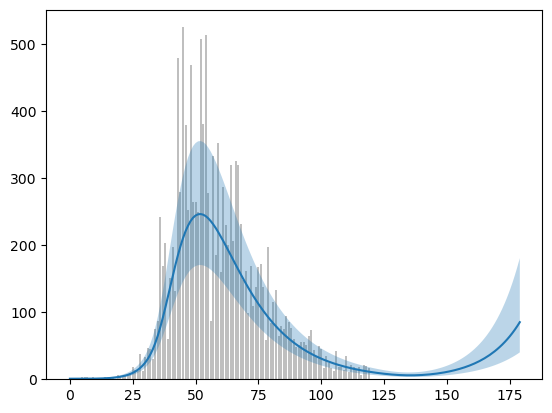

In [42]:
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)
plt.plot(model.predict_EY(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

## A = 0

In [33]:
Tf = 60
Af = np.zeros([Tf, d])

In [34]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0)

In [35]:
Ae = np.concatenate([A, Af], 0)

In [36]:
conf_band, beta_min, beta_max = \
model.confidence_R(Ae, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.197sec.
optimization at t = 2 finished, lapse: 0.169sec.
optimization at t = 3 finished, lapse: 0.167sec.
optimization at t = 4 finished, lapse: 0.165sec.
optimization at t = 5 finished, lapse: 0.168sec.
optimization at t = 6 finished, lapse: 0.166sec.
optimization at t = 7 finished, lapse: 0.167sec.
optimization at t = 8 finished, lapse: 0.167sec.
optimization at t = 9 finished, lapse: 0.166sec.
optimization at t = 10 finished, lapse: 0.165sec.
optimization at t = 11 finished, lapse: 0.167sec.
optimization at t = 12 finished, lapse: 0.166sec.
optimization at t = 13 finished, lapse: 0.169sec.
optimization at t = 14 finished, lapse: 0.166sec.
optimization at t = 15 finished, lapse: 0.166sec.
optimization at t = 16 finished, lapse: 0.166sec.
optimization at t = 17 finished, lapse: 0.167sec.
optimization at t = 18 finished, lapse: 0.166sec.
optimization at t = 19 finished, lapse: 0.167sec.
optimization at t = 20 finished, lapse: 0.166sec.
optimizat

optimization at t = 165 finished, lapse: 0.200sec.
optimization at t = 166 finished, lapse: 0.217sec.
optimization at t = 167 finished, lapse: 0.173sec.
optimization at t = 168 finished, lapse: 0.199sec.
optimization at t = 169 finished, lapse: 0.169sec.
optimization at t = 170 finished, lapse: 0.186sec.
optimization at t = 171 finished, lapse: 0.195sec.
optimization at t = 172 finished, lapse: 0.176sec.
optimization at t = 173 finished, lapse: 0.193sec.
optimization at t = 174 finished, lapse: 0.169sec.
optimization at t = 175 finished, lapse: 0.167sec.
optimization at t = 176 finished, lapse: 0.170sec.
optimization at t = 177 finished, lapse: 0.166sec.
optimization at t = 178 finished, lapse: 0.170sec.
optimization at t = 179 finished, lapse: 0.169sec.
optimization at t = 180 finished, lapse: 0.171sec.


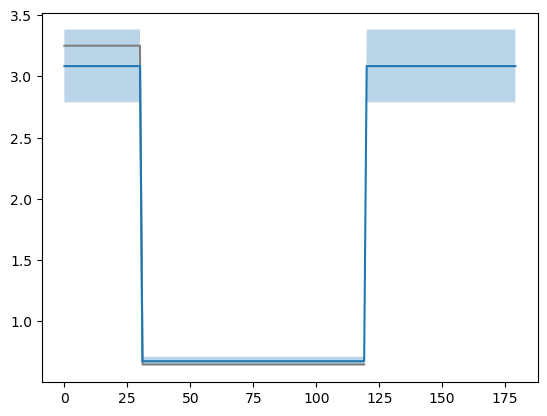

In [37]:
plt.plot(R, color='grey')
plt.plot(model.predict_R(Ae, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [38]:
conf_band, theta_min, theta_max = \
model.confidence_I(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.425sec.
optimization at t = 2 finished, lapse: 0.097sec.
optimization at t = 3 finished, lapse: 0.171sec.
optimization at t = 4 finished, lapse: 0.072sec.
optimization at t = 5 finished, lapse: 0.101sec.
optimization at t = 6 finished, lapse: 0.070sec.
optimization at t = 7 finished, lapse: 0.130sec.
optimization at t = 8 finished, lapse: 0.072sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 9 finished, lapse: 0.076sec.
optimization at t = 10 finished, lapse: 0.068sec.
optimization at t = 11 finished, lapse: 0.107sec.
optimization at t = 12 finished, lapse: 0.172sec.
optimization at t = 13 finished, lapse: 0.181sec.
optimization at t = 14 finished, lapse: 0.180sec.
optimization at t = 15 finished, lapse: 0.178sec.
optimization at t = 16 finished, lapse: 0.173sec.
optimization at t = 17 finished, lapse: 0.215sec.
optimization at t = 18 finished, lapse: 0.198sec.
optimization at t = 19 finished, lapse: 0.243sec.
optimization at t = 20 finished, lapse: 0.169sec.
optimization at t = 21 finished, lapse: 0.193sec.
optimization at t = 22 finished, lapse: 0.221sec.
optimization at t = 23 finished, lapse: 0.249sec.
optimization at t = 24 finished, lapse: 0.154sec.
optimization at t = 25 finished, lapse: 0.191sec.
optimization at t = 26 finished, lapse: 0.175sec.
optimization at t = 27 finished, lapse: 0.201sec.
optimization at t = 28 finished, lapse: 0.226sec.
o

optimization at t = 172 finished, lapse: 3.471sec.
optimization at t = 173 finished, lapse: 2.398sec.
optimization at t = 174 finished, lapse: 1.390sec.
optimization at t = 175 finished, lapse: 3.323sec.
optimization at t = 176 finished, lapse: 1.565sec.
optimization at t = 177 finished, lapse: 1.336sec.
optimization at t = 178 finished, lapse: 3.572sec.
optimization at t = 179 finished, lapse: 2.032sec.
optimization at t = 180 finished, lapse: 3.390sec.


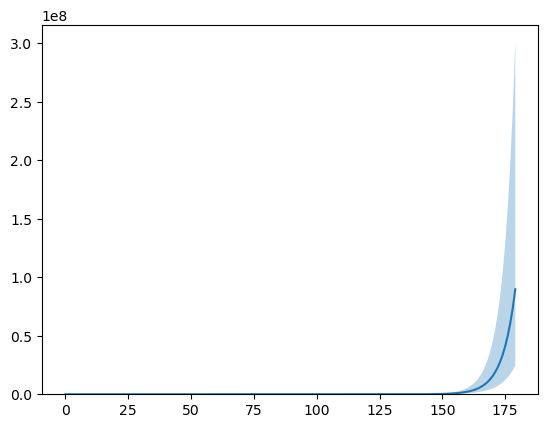

In [39]:
plt.bar(np.arange(T), I, color='grey', alpha=0.5)
plt.plot(model.predict_I(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [40]:
conf_band, theta_min, theta_max = \
model.confidence_EY(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 1.213sec.
optimization at t = 2 finished, lapse: 0.265sec.
optimization at t = 3 finished, lapse: 1.521sec.
optimization at t = 4 finished, lapse: 0.825sec.
optimization at t = 5 finished, lapse: 0.421sec.
optimization at t = 6 finished, lapse: 1.639sec.
optimization at t = 7 finished, lapse: 0.367sec.
optimization at t = 8 finished, lapse: 0.352sec.
optimization at t = 9 finished, lapse: 0.256sec.
optimization at t = 10 finished, lapse: 0.529sec.
optimization at t = 11 finished, lapse: 0.506sec.
optimization at t = 12 finished, lapse: 0.361sec.
optimization at t = 13 finished, lapse: 0.148sec.
optimization at t = 14 finished, lapse: 0.188sec.
optimization at t = 15 finished, lapse: 0.114sec.
optimization at t = 16 finished, lapse: 0.132sec.
optimization at t = 17 finished, lapse: 0.311sec.
optimization at t = 18 finished, lapse: 0.206sec.
optimization at t = 19 finished, lapse: 0.172sec.
optimization at t = 20 finished, lapse: 0.123sec.
optimizat

optimization at t = 164 finished, lapse: 2.019sec.
optimization at t = 165 finished, lapse: 2.136sec.
optimization at t = 166 finished, lapse: 2.582sec.
optimization at t = 167 finished, lapse: 2.338sec.
optimization at t = 168 finished, lapse: 2.564sec.
optimization at t = 169 finished, lapse: 2.137sec.
optimization at t = 170 finished, lapse: 3.161sec.
optimization at t = 171 finished, lapse: 2.752sec.
optimization at t = 172 finished, lapse: 15.261sec.
optimization at t = 173 finished, lapse: 7.215sec.
optimization at t = 174 finished, lapse: 8.237sec.
optimization at t = 175 finished, lapse: 5.713sec.
optimization at t = 176 finished, lapse: 5.082sec.
optimization at t = 177 finished, lapse: 12.050sec.
optimization at t = 178 finished, lapse: 32.123sec.
optimization at t = 179 finished, lapse: 21.457sec.
optimization at t = 180 finished, lapse: 40.640sec.


(0.0, 2000.0)

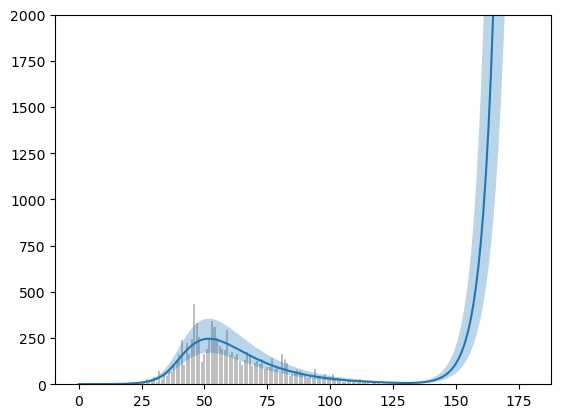

In [41]:
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)
plt.plot(model.predict_EY(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)
plt.ylim(0,2000)